In [5]:
# Cell 1: Import Libraries
import os
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.layers import (
    Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization,
    RandomFlip, RandomRotation, RandomZoom
)

In [6]:
class WildfireClassifier:
    def __init__(self, img_size=64):
        self.img_size = img_size
        self.model = None
        self.history = None
        self.class_names = ['nowildfire', 'wildfire']

    def load_and_preprocess_data(self, train_dir, valid_dir, test_dir):
        """Load and preprocess images from directories"""
        def load_data_from_dir(directory):
            x_data = []
            y_data = []
            for class_name in os.listdir(directory):
                class_dir = os.path.join(directory, class_name)
                class_label = 1 if class_name == 'wildfire' else 0
                for filename in os.listdir(class_dir):
                    img_path = os.path.join(class_dir, filename)
                    img = cv2.imread(img_path)
                    img = cv2.resize(img, (self.img_size, self.img_size))
                    img = img / 255.0  # Normalize
                    x_data.append(img)
                    y_data.append(class_label)
            return np.array(x_data), np.array(y_data)

        print("Loading training data...")
        self.x_train, self.y_train = load_data_from_dir(train_dir)
        print("Loading validation data...")
        self.x_val, self.y_val = load_data_from_dir(valid_dir)
        print("Loading test data...")
        self.x_test, self.y_test = load_data_from_dir(test_dir)

        # Compute class weights
        self.class_weights = compute_class_weight(
            'balanced',
            classes=np.unique(self.y_train),
            y=self.y_train
        )
        self.class_weight_dict = dict(enumerate(self.class_weights))

    def build_model(self):
        """Build and compile the CNN model"""
        # Create data augmentation layer
        data_augmentation = Sequential([
            RandomFlip("horizontal"),
            RandomRotation(0.2),
            RandomZoom(0.2),
        ])

        # Create model
        self.model = Sequential([
            data_augmentation,
            Conv2D(32, (3, 3), activation='relu', input_shape=(self.img_size, self.img_size, 3)),
            MaxPooling2D(),
            Conv2D(64, (3, 3), activation='relu'),
            MaxPooling2D(),
            Conv2D(64, (3, 3), activation='relu'),
            MaxPooling2D(),
            Dropout(0.2),
            Flatten(),
            Dense(64, activation='relu'),
            Dropout(0.5),
            Dense(1, activation='sigmoid')
        ])

        # Learning rate schedule
        initial_learning_rate = 0.001
        lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
            initial_learning_rate,
            decay_steps=10000,
            decay_rate=0.9
        )
        optimizer = Adam(learning_rate=lr_schedule)

        # Compile model
        self.model.compile(
            optimizer=optimizer,
            loss='binary_crossentropy',
            metrics=['accuracy']
        )

        return self.model

    def train(self, epochs=50, batch_size=32):
        """Train the model"""
        callbacks = [
            tf.keras.callbacks.EarlyStopping(
                monitor='val_loss',
                patience=10,
                restore_best_weights=True
            )
        ]

        self.history = self.model.fit(
            self.x_train,
            self.y_train,
            validation_data=(self.x_val, self.y_val),
            epochs=epochs,
            batch_size=batch_size,
            class_weight=self.class_weight_dict,
            callbacks=callbacks
        )

    def evaluate(self):
        """Evaluate the model and display results"""
        # Test set evaluation
        test_loss, test_accuracy = self.model.evaluate(self.x_test, self.y_test)
        print(f'\nTest Accuracy: {test_accuracy:.4f}')

        # Get predictions
        y_pred = self.model.predict(self.x_test)
        y_pred_classes = (y_pred > 0.5).astype(int)

        # Display confusion matrix
        cm = confusion_matrix(self.y_test, y_pred_classes)
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
        plt.title('Confusion Matrix')
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')
        plt.show()

        # Display classification report
        print("\nClassification Report:")
        print(classification_report(self.y_test, y_pred_classes))

    def plot_training_history(self):
        """Plot training history"""
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

        # Accuracy plot
        ax1.plot(self.history.history['accuracy'], label='Training')
        ax1.plot(self.history.history['val_accuracy'], label='Validation')
        ax1.set_title('Model Accuracy')
        ax1.set_xlabel('Epoch')
        ax1.set_ylabel('Accuracy')
        ax1.legend()

        # Loss plot
        ax2.plot(self.history.history['loss'], label='Training')
        ax2.plot(self.history.history['val_loss'], label='Validation')
        ax2.set_title('Model Loss')
        ax2.set_xlabel('Epoch')
        ax2.set_ylabel('Loss')
        ax2.legend()

        plt.tight_layout()
        plt.show()

    def save_model(self, filepath):
        """Save the model"""
        self.model.save(filepath)

    def load_saved_model(self, filepath):
        """Load a saved model"""
        self.model = load_model(filepath)

    def predict_single_image(self, image_path):
        """Predict whether a single image contains a wildfire"""
        # Load and preprocess the image
        img = cv2.imread(image_path)
        img = cv2.resize(img, (self.img_size, self.img_size))
        img = img / 255.0
        img = np.expand_dims(img, axis=0)

        # Make prediction
        prediction = self.model.predict(img)[0][0]
        predicted_class = 'Wildfire' if prediction > 0.5 else 'No Wildfire'
        confidence = prediction if prediction > 0.5 else 1 - prediction

        return {
            'class': predicted_class,
            'confidence': float(confidence),
            'raw_prediction': float(prediction)
        }

In [3]:
# Define the directories
valid_dir = r'C:\Users\shash\Downloads\archive\valid'     # Replace with your valid directory
train_dir = r'C:\Users\shash\Downloads\archive\train' # Replace with your train directory
test_dir =  r'C:\Users\shash\Downloads\archive\test'        # Replace with your test directory

In [4]:
classifier = WildfireClassifier(img_size=64)

In [5]:
classifier.load_and_preprocess_data(train_dir, valid_dir, test_dir)

Loading training data...
Loading validation data...
Loading test data...


In [6]:
classifier.build_model()
classifier.train(epochs=50, batch_size=32)

C:\Users\shash\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
946/946 ━━━━━━━━━━━━━━━━━━━━ 55s 55ms/step - accuracy: 0.8602 - loss: 0.3146 - val_accuracy: 0.7908 - val_loss: 0.8052
Epoch 2/50
946/946 ━━━━━━━━━━━━━━━━━━━━ 71s 75ms/step - accuracy: 0.9176 - loss: 0.2139 - val_accuracy: 0.7451 - val_loss: 0.6565
Epoch 3/50
946/946 ━━━━━━━━━━━━━━━━━━━━ 69s 73ms/step - accuracy: 0.9302 - loss: 0.1899 - val_accuracy: 0.8725 - val_loss: 0.3029
Epoch 4/50
946/946 ━━━━━━━━━━━━━━━━━━━━ 78s 82ms/step - accuracy: 0.9316 - loss: 0.1835 - val_accuracy: 0.9062 - val_loss: 0.2707
Epoch 5/50
946/946 ━━━━━━━━━━━━━━━━━━━━ 75s 79ms/step - accuracy: 0.9392 - loss: 0.1619 - val_accuracy: 0.8924 - val_loss: 0.2800
Epoch 6/50
946/946 ━━━━━━━━━━━━━━━━━━━━ 68s 72ms/step - accuracy: 0.9395 - loss: 0.1617 - val_accuracy: 0.9081 - val_loss: 0.2383
Epoch 7/50
946/946 ━━━━━━━━━━━━━━━━━━━━ 76s 80ms/step - accuracy: 0.9419 - loss: 0.1592 - val_accuracy: 0.8976 - val_loss: 0.2984
Epoch 8/50
946/946 ━━━━━━━━━━━━━━━━━━━━ 61s 65ms/step - accuracy: 0.9438 - loss: 0.1534 - 

197/197 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.9491 - loss: 0.1343

Test Accuracy: 0.9498
197/197 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step


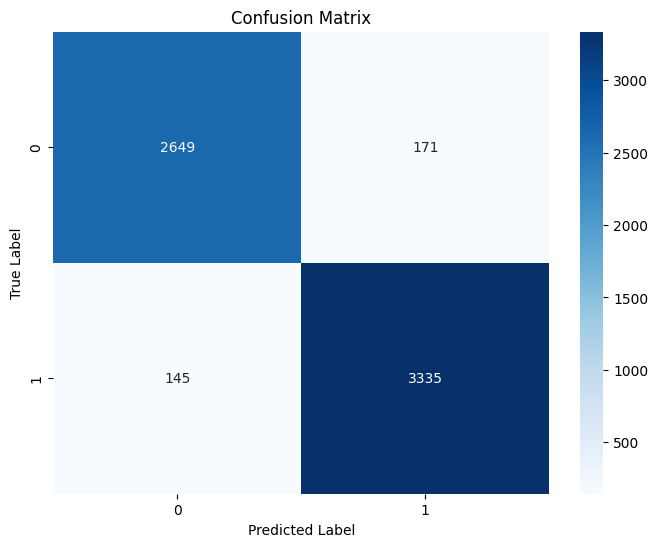


Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.94      0.94      2820
           1       0.95      0.96      0.95      3480

    accuracy                           0.95      6300
   macro avg       0.95      0.95      0.95      6300
weighted avg       0.95      0.95      0.95      6300



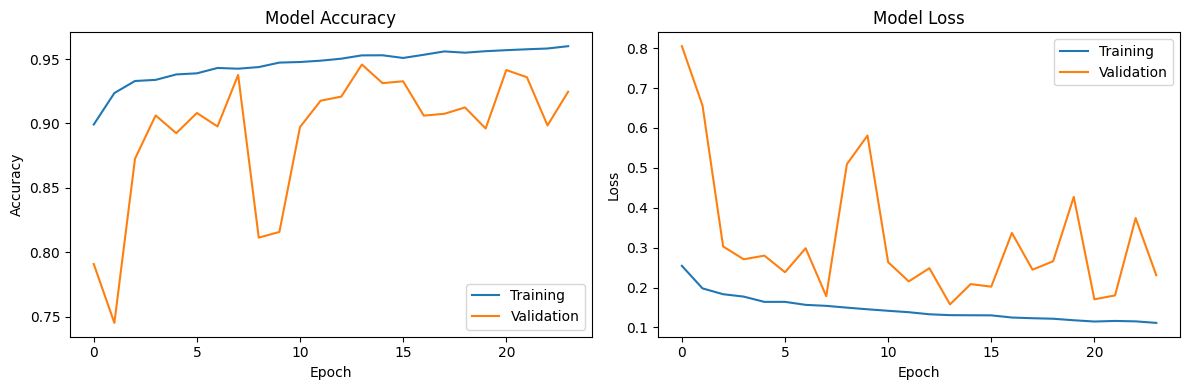

In [7]:
classifier.evaluate()
classifier.plot_training_history()

In [8]:
classifier.save_model('wildfire_classifier.h5')

In [9]:
test_image_path = r'C:\BA\SEM4\EDA\ML\-79.4733,47.6094.jpg'  # Update this path
result = classifier.predict_single_image(test_image_path)
print(f"Prediction: {result['class']}")
print(f"Confidence: {result['confidence']:.2%}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
Prediction: Wildfire
Confidence: 50.04%


In [10]:
def batch_process_images(image_directory):
    """
    Process all images in a directory
    
    Parameters:
    image_directory (str): Path to directory containing images
    
    Returns:
    pandas.DataFrame: Results of batch processing
    """
    results = []
    
    # Process each image in the directory
    for filename in os.listdir(image_directory):
        if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
            image_path = os.path.join(image_directory, filename)
            try:
                # Check if file exists and is valid
                if not os.path.exists(image_path):
                    result = {"error": "Image file not found"}
                else:
                    # Load and process image
                    img = cv2.imread(image_path)
                    if img is None:
                        result = {"error": "Invalid image file"}
                    else:
                        # Make prediction using classifier
                        result = classifier.predict_single_image(image_path)
                        result = {
                            "success": True,
                            "prediction": result['class'],
                            "confidence": f"{result['confidence']:.2%}",
                            "raw_score": result['raw_prediction']
                        }
            except Exception as e:
                result = {"error": f"Unexpected error: {str(e)}"}
            
            results.append({
                'filename': filename,
                'result': result
            })
    
    # Create a summary DataFrame
    df = pd.DataFrame(results)
    
    # Display summary statistics
    print("\nProcessing Summary:")
    print(f"Total images processed: {len(results)}")
    
    if len(results) > 0:
        successful = df[df['result'].apply(lambda x: 'success' in x)]
        print(f"Successful predictions: {len(successful)}")
        
        if len(successful) > 0:
            predictions = successful['result'].apply(lambda x: x['prediction'])
            print("\nPrediction distribution:")
            print(predictions.value_counts())
            
            # Calculate average confidence
            confidences = successful['result'].apply(lambda x: float(x['confidence'].strip('%')) / 100)
            print(f"\nAverage confidence: {confidences.mean():.2%}")
            
            # High confidence predictions (>90%)
            high_conf = confidences[confidences > 0.9]
            print(f"High confidence predictions (>90%): {len(high_conf)}")
    
    return df

In [11]:
# test_directory = r'C:\Users\shash\Downloads\archive\test\wildfire'  
# results_df = batch_process_images(test_directory)
# print("\nBatch Processing Results:")
# print(results_df.head())

In [12]:
def analyze_model_performance(confidence_threshold=0.8):
    """
    Analyze model performance with different confidence thresholds
    
    Parameters:
    confidence_threshold (float): Baseline confidence threshold for analysis
    
    Returns:
    pandas.DataFrame: Performance metrics for different thresholds
    """
    # Get predictions for test set
    predictions = classifier.model.predict(classifier.x_test)
    
    # Calculate metrics for different confidence thresholds
    thresholds = np.arange(0.5, 1.0, 0.1)
    results = []
    
    for threshold in thresholds:
        # Apply threshold
        y_pred = (predictions > threshold).astype(int)
        
        # Calculate metrics
        report = classification_report(classifier.y_test, y_pred, output_dict=True)
        
        # Store results
        results.append({
            'threshold': threshold,
            'accuracy': report['accuracy'],
            'precision': report['weighted avg']['precision'],
            'recall': report['weighted avg']['recall'],
            'f1': report['weighted avg']['f1-score']
        })
    
    # Create DataFrame
    df = pd.DataFrame(results)
    
    # Create visualization
    plt.figure(figsize=(12, 6))
    
    # Plot metrics
    metrics = ['accuracy', 'precision', 'recall', 'f1']
    colors = ['blue', 'green', 'red', 'purple']
    
    for metric, color in zip(metrics, colors):
        plt.plot(df['threshold'], df[metric], 
                label=metric.capitalize(), 
                color=color, 
                marker='o')
    
    plt.xlabel('Confidence Threshold')
    plt.ylabel('Score')
    plt.title('Model Metrics vs Confidence Threshold')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Add vertical line at confidence_threshold
    plt.axvline(x=confidence_threshold, 
                color='gray', 
                linestyle='--', 
                alpha=0.5,
                label=f'Threshold ({confidence_threshold})')
    
    plt.tight_layout()
    plt.show()
    
    # Print optimal thresholds
    print("\nOptimal Thresholds:")
    for metric in metrics:
        optimal_threshold = df.loc[df[metric].idxmax(), 'threshold']
        max_value = df[metric].max()
        print(f"Best {metric}: {max_value:.3f} at threshold {optimal_threshold:.1f}")
    
    return df

197/197 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step


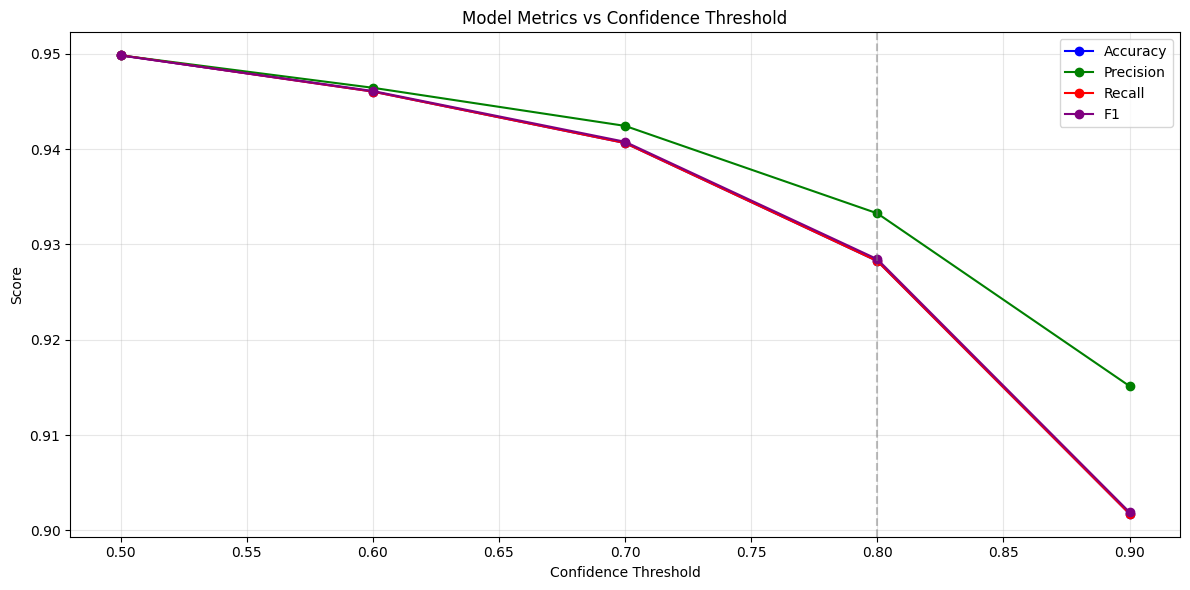


Optimal Thresholds:
Best accuracy: 0.950 at threshold 0.5
Best precision: 0.950 at threshold 0.5
Best recall: 0.950 at threshold 0.5
Best f1: 0.950 at threshold 0.5

Performance Metrics:
   threshold  accuracy  precision    recall        f1
0        0.5  0.949841   0.949828  0.949841  0.949818
1        0.6  0.946032   0.946430  0.946032  0.946093
2        0.7  0.940635   0.942433  0.940635  0.940765
3        0.8  0.928254   0.933259  0.928254  0.928451
4        0.9  0.901746   0.915140  0.901746  0.901912


In [13]:
performance_metrics = analyze_model_performance()
print("\nPerformance Metrics:")
print(performance_metrics)

In [14]:
# Step 1: Create the classifier object
classifier = WildfireClassifier(img_size=64)

# Step 2: Load the previously saved model
classifier.load_saved_model('wildfire_classifier.h5')

# Step 3: Predict on a new image
test_image_path = r'C:\BA\SEM4\EDA\ML\-79.4733,47.6094.jpg'
result = classifier.predict_single_image(test_image_path)

print(f"Prediction: {result['class']}")
print(f"Confidence: {result['confidence']:.2%}")



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
Prediction: Wildfire
Confidence: 50.04%


In [3]:
classifier = WildfireClassifier(img_size=64)
classifier.load_saved_model('wildfire_classifier.h5')

In [4]:
test_image_path = r'C:\BA\SEM4\EDA\ML\-79.4733,47.6094.jpg'
result = classifier.predict_single_image(test_image_path)

print(f"Prediction: {result['class']}")
print(f"Confidence: {result['confidence']:.2%}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
Prediction: Wildfire
Confidence: 50.04%
